
<span style = "font-size : 40px">SMA Crossover Strategy Backtesting (BTC/USD)</span>

<span style = "font-size : 30px">Methodology / Approach </span>



- I decided to go with a Swing Trading approach (1-day Timeframe) given Bitcoin's price sensitivity to news (e.g. Trump announcements). I have experienced it first hand when manually trading BTC tagged stock intra-day and sticking to an indicator based strategy on a 15-minute timeframe for example could lead to extreme portfolio volatility and the strategy is not feasible to run automated.

- To evaluate the strategy's performance, its volatility, sharpe ratio (risk-adjusted return), annualized returns, max drawdown will be calculated.

- These metrics will be compared to a benchmark which will be the buy/hold strategy which will simply be tagged to the BTC/USD price. 

- Matplotlib will be used to plot graphs of the portfolio_value vs buy_hold_value to visualize the Alpha that the strategy generates

- Use of AI : Parts of the code was developed with assistance of Github Copilot. It was used to aid in debugging, syntax and speeding up of implementation. The code was then reviewed and implemented by me so as to ensure accuracy.

<span style = "font-size : 30px">Trading Considerations </span>


- Choice of Strategy : BTC is akin to a momentum stock with strong intra-day volatility but clearer long term trends (Bullish vs Bearish). Adopting an SMA crossover strategy enables me to identify these mid-long term trends utilizing a short term SMA crossover of the long term SMA as a buy signal, and the reverse as a sell signal.

- Simple Moving Average (SMA) = (Px + Px-1 + Px-2 + ...Px-n)/n where n is the number of periods

- SMAshort > SMAlong indicates Bullish momentum since recent prices over a period have been above the longer term average price(SMAlong)

- Using that signal we buy into the trend (almost like trend trading but with SMA crossover confirmation)

- SMAlong > SMAshort indicates Bearish momentum or a reversal in an uptrend which would be a signal to either short (not included in our strategy) or exit a long position. This crossover indicates that short term prices are lower than the long term average.

- Implementation : The Strategy will not take any short positions to avoid unexpected losses in a trending market. BTC has a long-term bullish performance and with Trump's backing of crypto, BTC will be expected to trend upwards. Shorting will also result in the need to account for margin accounts and for simplicity I have kept the trading account akin to a cash account with no leverage.



<span style = "font-size : 30px">Imports </span>


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<span style = "font-size : 30px">Handling Data</span>

- Data was downloaded as a csv file from CoinGecko (https://www.coingecko.com/en/coins/bitcoin/historical_data)
- It was then converted into a Dataframe which is the underlying data for strategy implementation


In [23]:
data = pd.read_csv("btc-usd-max.csv", parse_dates=True, index_col='snapped_at')
print("loaded data:")
print(data.head())
print(f"shape: {data.shape}")

loaded data:
                            price    market_cap  total_volume
snapped_at                                                   
2013-04-28 00:00:00+00:00  135.30  1.500518e+09           0.0
2013-04-29 00:00:00+00:00  141.96  1.575032e+09           0.0
2013-04-30 00:00:00+00:00  135.30  1.501657e+09           0.0
2013-05-01 00:00:00+00:00  117.00  1.298952e+09           0.0
2013-05-02 00:00:00+00:00  103.43  1.148668e+09           0.0
shape: (4494, 3)


<span style = "font-size : 30px">SMA_crossover_strategy Function </span>

1. A pandas Dataframe is created with the copy of the data from the csv file. we will run the strategy using this Dataframe.

2. We add new columns for our trading decisions and initialize them with a 0 value.

3. Error handling : We ensure that the SMA is not calculated until the long_sma becomes valid. i.e. there are atleast 50 days of data before calculating if the long_SMA = 50.

4. Build the trading logic based on the 'trade' column. When there is a bullish SMA crossover, 'trade' columns registers 1.0, which executes a buy. The reverse results in a 0.0 value which executes a sell

5. The returns and portfolio value are calculated for both the benchmark (SMA crossover) and SMA crossover.



In [24]:
def sma_crossover_strategy(data, short_sma, long_sma, initial_capital=10000):
    strat = pd.DataFrame(index=data.index)
    strat['price'] = data['price'].copy()
    
    # calc moving averages
    strat['sma_short'] = data['price'].rolling(window=short_sma, min_periods=short_sma).mean()
    strat['sma_long'] = data['price'].rolling(window=long_sma, min_periods=long_sma).mean()
    
    strat['signal'] = 0.0
    strat['position'] = 0.0
    strat['trade'] = 0.0
    strat['cash'] = initial_capital
    strat['shares'] = 0.0
    strat['portfolio_value'] = initial_capital
    strat['returns'] = 0.0
    
    valid_idx = strat['sma_long'].notna()
    
    strat.loc[valid_idx, 'signal'] = np.where(
        strat.loc[valid_idx, 'sma_short'] > strat.loc[valid_idx, 'sma_long'], 1.0, 0.0
    )
    
    strat['position'] = strat['signal']
    strat['trade'] = strat['position'].diff()
    
    # fix first row
    first_valid_idx = strat['sma_long'].first_valid_index()
    if first_valid_idx is not None:
        strat.loc[first_valid_idx, 'trade'] = strat.loc[first_valid_idx, 'position']
    
    # execute trades
    cash = initial_capital
    shares = 0.0
    
    for i, (timestamp, row) in enumerate(strat.iterrows()):
        current_price = row['price']
        trade_signal = row['trade']
        
        if trade_signal == 1.0 and cash > 0:  # buy
            shares_to_buy = cash / current_price
            shares += shares_to_buy
            cash = 0.0
            
        elif trade_signal == -1.0 and shares > 0:  # sell
            cash += shares * current_price
            shares = 0.0
        
        strat.loc[timestamp, 'cash'] = cash
        strat.loc[timestamp, 'shares'] = shares
        strat.loc[timestamp, 'portfolio_value'] = cash + (shares * current_price)
    
    strat['returns'] = strat['portfolio_value'].pct_change().fillna(0)
    strat['cumulative_returns'] = (1 + strat['returns']).cumprod()
    
    # benchmark
    strat['buy_hold_value'] = initial_capital * (strat['price'] / strat['price'].iloc[0])
    strat['buy_hold_returns'] = strat['buy_hold_value'].pct_change().fillna(0)
    strat['buy_hold_cumulative'] = (1 + strat['buy_hold_returns']).cumprod()
    
    return strat


<span style = "font-size : 30px">Calculation of Strategy Performance Metrics </span>

1. we process the data by filtering for the 'returns' column and return an empty output when the column is empty

2. Calculate the Volatility = stdev * sqrt(n), n = no. of time periods
   
3. Calculate Sharpe Ratio = (Annualized return)/volatility

4. Calculate the drawdown by taking the difference of the current price from the previous peak using the difference as a percentage of the rolling_max. The max drawdown would be the greatest magnitude of drawdown.

In [25]:
#Clean Data and Calculate Metrics
def calc_metrics(strat_results):
    clean_data = strat_results.dropna(subset=['returns'])
    
    if len(clean_data) == 0:
        return {}
    
    total_return = (clean_data['portfolio_value'].iloc[-1] / clean_data['portfolio_value'].iloc[0] - 1) * 100
    buy_hold_return = (clean_data['buy_hold_value'].iloc[-1] / clean_data['buy_hold_value'].iloc[0] - 1) * 100
    
    days = (clean_data.index[-1] - clean_data.index[0]).days
    years = days / 365


#Annualize the returns 
    if years > 0:
        annual_return = ((clean_data['portfolio_value'].iloc[-1] / clean_data['portfolio_value'].iloc[0]) ** (1/years) - 1) * 100
        annual_buy_hold = ((clean_data['buy_hold_value'].iloc[-1] / clean_data['buy_hold_value'].iloc[0]) ** (1/years) - 1) * 100
    else:
        annual_return = total_return
        annual_buy_hold = buy_hold_return
    
    strategy_vol = clean_data['returns'].std() * np.sqrt(365) * 100
    buy_hold_vol = clean_data['buy_hold_returns'].std() * np.sqrt(365) * 100
    
    sharpe_ratio = annual_return / strategy_vol if strategy_vol > 0 else 0
    buy_hold_sharpe = annual_buy_hold  / buy_hold_vol if buy_hold_vol > 0 else 0
    
#Drawdown calculation
    rolling_max = clean_data['portfolio_value'].expanding().max()
    drawdown = (clean_data['portfolio_value'] - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    bh_rolling_max = clean_data['buy_hold_value'].expanding().max()
    bh_drawdown = (clean_data['buy_hold_value'] - bh_rolling_max) / bh_rolling_max * 100
    bh_max_drawdown = bh_drawdown.min()
    
    num_trades = (clean_data['trade'] != 0).sum()
    
    trade_returns = clean_data[clean_data['trade'] != 0]['returns']
    win_rate = (trade_returns > 0).mean() * 100 if len(trade_returns) > 0 else 0

#Output the metrics in a dict   
    return {
        'Total Return (%)': round(total_return, 2),
        'Buy & Hold Return (%)': round(buy_hold_return, 2),
        'Annualized Return (%)': round(annual_return, 2),
        'Annualized Buy & Hold (%)': round(annual_buy_hold, 2),
        'Volatility (%)': round(strategy_vol, 2),
        'Buy & Hold Volatility (%)': round(buy_hold_vol, 2),
        'Sharpe Ratio': round(sharpe_ratio, 2),
        'Buy & Hold Sharpe': round(buy_hold_sharpe, 2),
        'Max Drawdown (%)': round(max_drawdown, 2),
        'Buy & Hold Max DD (%)': round(bh_max_drawdown, 2),
        'Number of Trades': int(num_trades),
        'Win Rate (%)': round(win_rate, 2),
        'Total Days': days
    }

<span style = "font-size : 30px">Plotting of results </span>

1. Plotting of 3 different sub Graphs
- Price and signals
- Buy/Hold vs SMA crossover Strategy
- Total Returns, portfolio Value



In [26]:
def plot_results(strat_results, short_sma, long_sma):
    fig, axes = plt.subplots(3, 1, figsize=(15, 16))
    fig.suptitle(f'SMA Strategy {short_sma}/{long_sma}', fontsize=16)
    
#Trading Signals and BTC/USD price    
    axes[0].plot(strat_results.index, strat_results['price'], label='BTC', linewidth=1)
    axes[0].plot(strat_results.index, strat_results['sma_short'], label=f'SMA {short_sma}')
    axes[0].plot(strat_results.index, strat_results['sma_long'], label=f'SMA {long_sma}')
    
    buy_signals = strat_results[strat_results['trade'] == 1]
    sell_signals = strat_results[strat_results['trade'] == -1]
    
    if len(buy_signals) > 0:
        axes[0].scatter(buy_signals.index, buy_signals['price'], color='green', marker='^', s=40, label='Buy')
    if len(sell_signals) > 0:
        axes[0].scatter(sell_signals.index, sell_signals['price'], color='red', marker='v', s=40, label='Sell')
    
    axes[0].set_title('Price & Signals')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
#Strategy vs Buy/Hold
    axes[1].plot(strat_results.index, strat_results['portfolio_value'], label='Strategy', color='blue')
    axes[1].plot(strat_results.index, strat_results['buy_hold_value'], label='Buy & Hold', color='orange')
    axes[1].set_title('Portfolio Value')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
#Returns
    axes[2].plot(strat_results.index, (strat_results['cumulative_returns'] - 1) * 100, label='Strategy', color='blue')
    axes[2].plot(strat_results.index, (strat_results['buy_hold_cumulative'] - 1) * 100, label='Buy & Hold', color='orange')
    axes[2].set_title('Cumulative Returns %')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    

    plt.tight_layout()
    plt.show()


<span style = "font-size : 30px">Walk Forward Test</span>

1. Took the window as 1 year and each step to be 2 months
2. The strategy will be tested on 2 months of data from the start point

In [27]:
def walk_forward_test(data, short_sma, long_sma, initial_capital=10000, window_size=365, step_size=60):
    results = []
    
    for start_idx in range(0, len(data) - window_size, step_size):
        end_idx = start_idx + window_size
        window_data = data.iloc[start_idx:end_idx]
        
        if len(window_data) < long_sma:
            continue
            
        strat_result = sma_crossover_strategy(window_data, short_sma, long_sma, initial_capital)
        metrics = calc_metrics(strat_result)
        
        if metrics:
            metrics['start_date'] = window_data.index[0]
            metrics['end_date'] = window_data.index[-1]
            results.append(metrics)
    
    return pd.DataFrame(results)

<span style = "font-size : 30px">Run and output Strategy</span>


running 10/50 crossover...

results:
metric                         strategy        buy hold       
------------------------------------------------------------
Sharpe Ratio                   1.6             1.01           
Number of Trades               100
Win Rate (%)                   20.0
Total Days                     4495


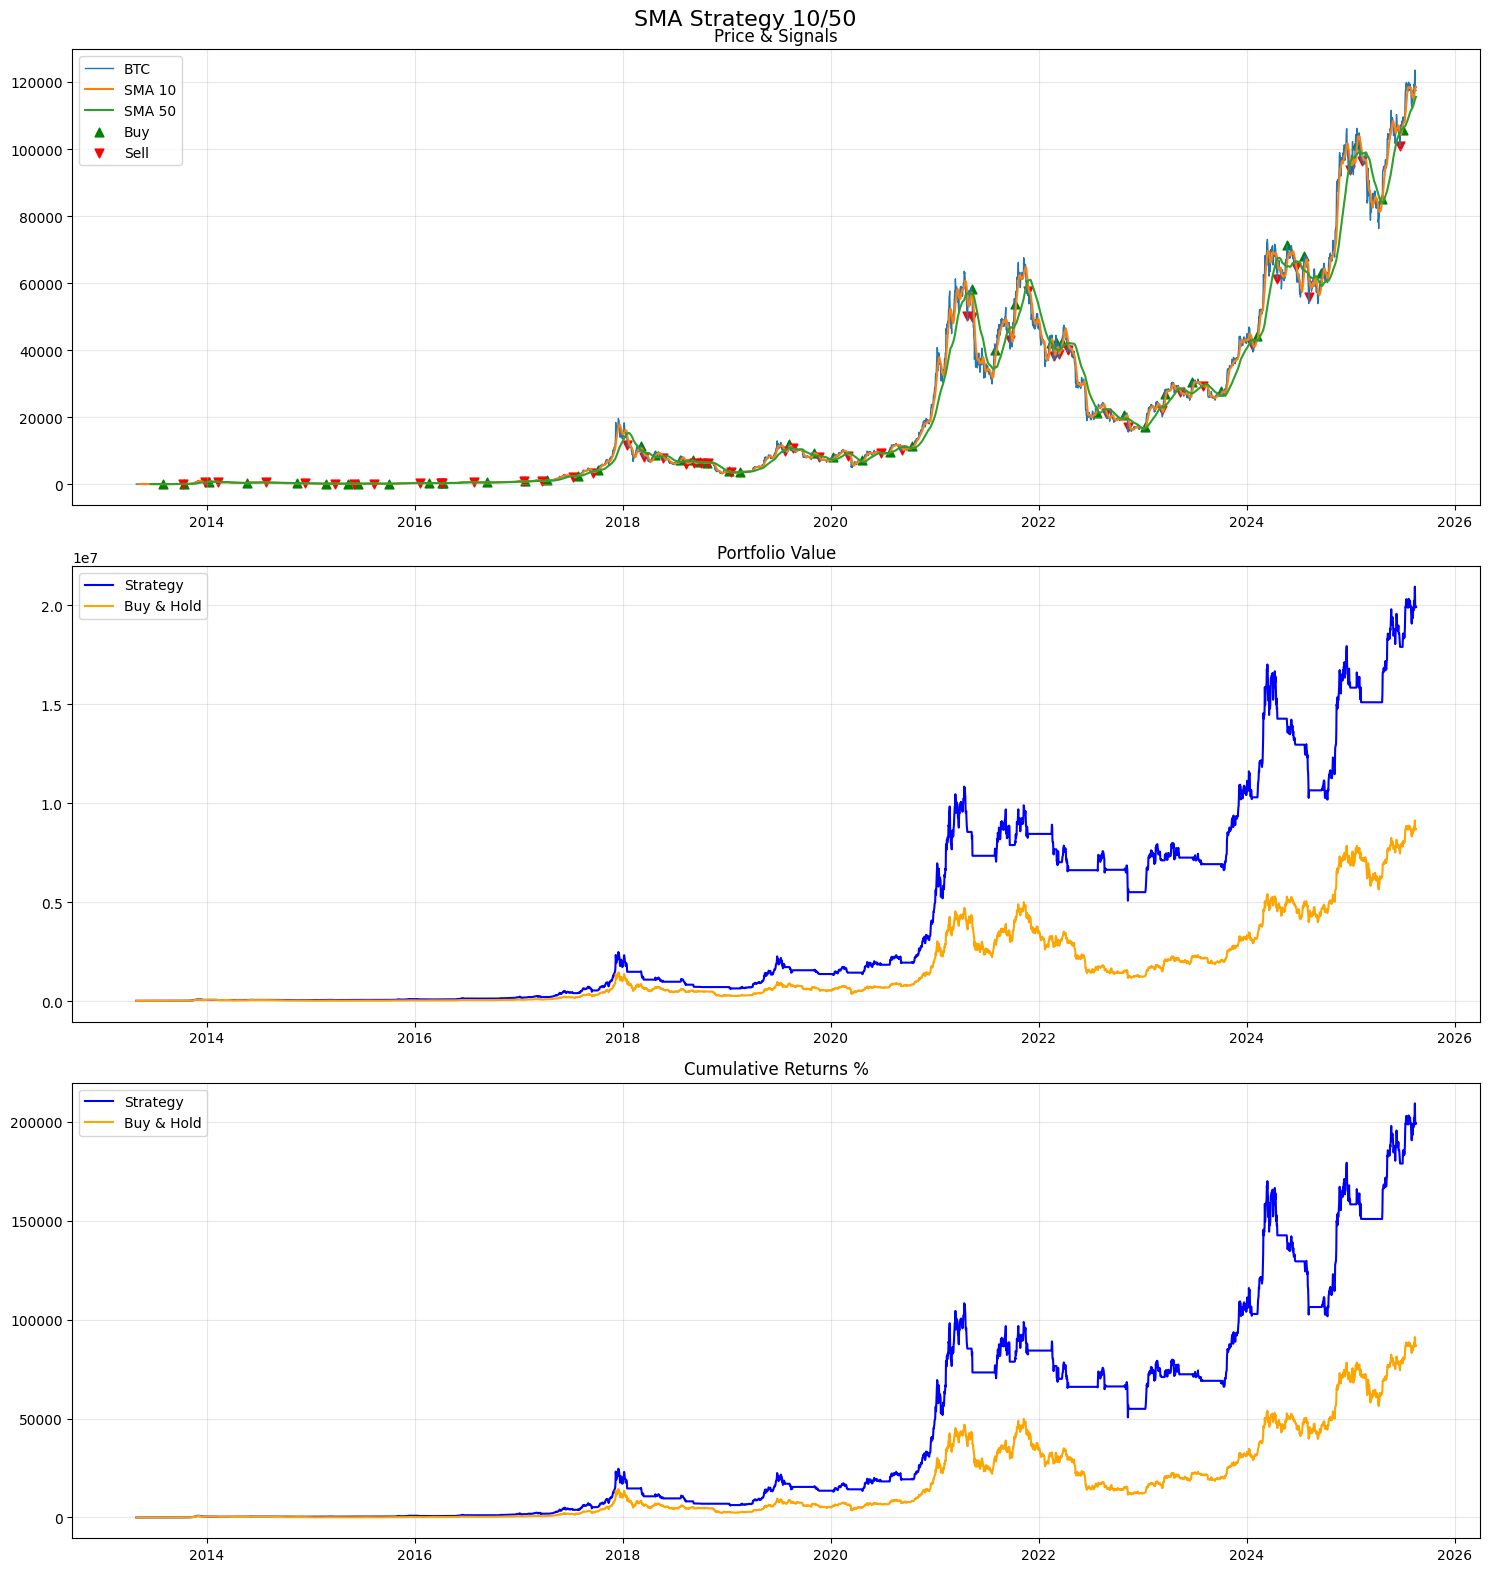


walk forward test...
tested 69 windows
avg return: 110.53%
std dev of total return: 174.54%
positive windows: 76.8%
best: 976.87%
worst: -52.39%
done


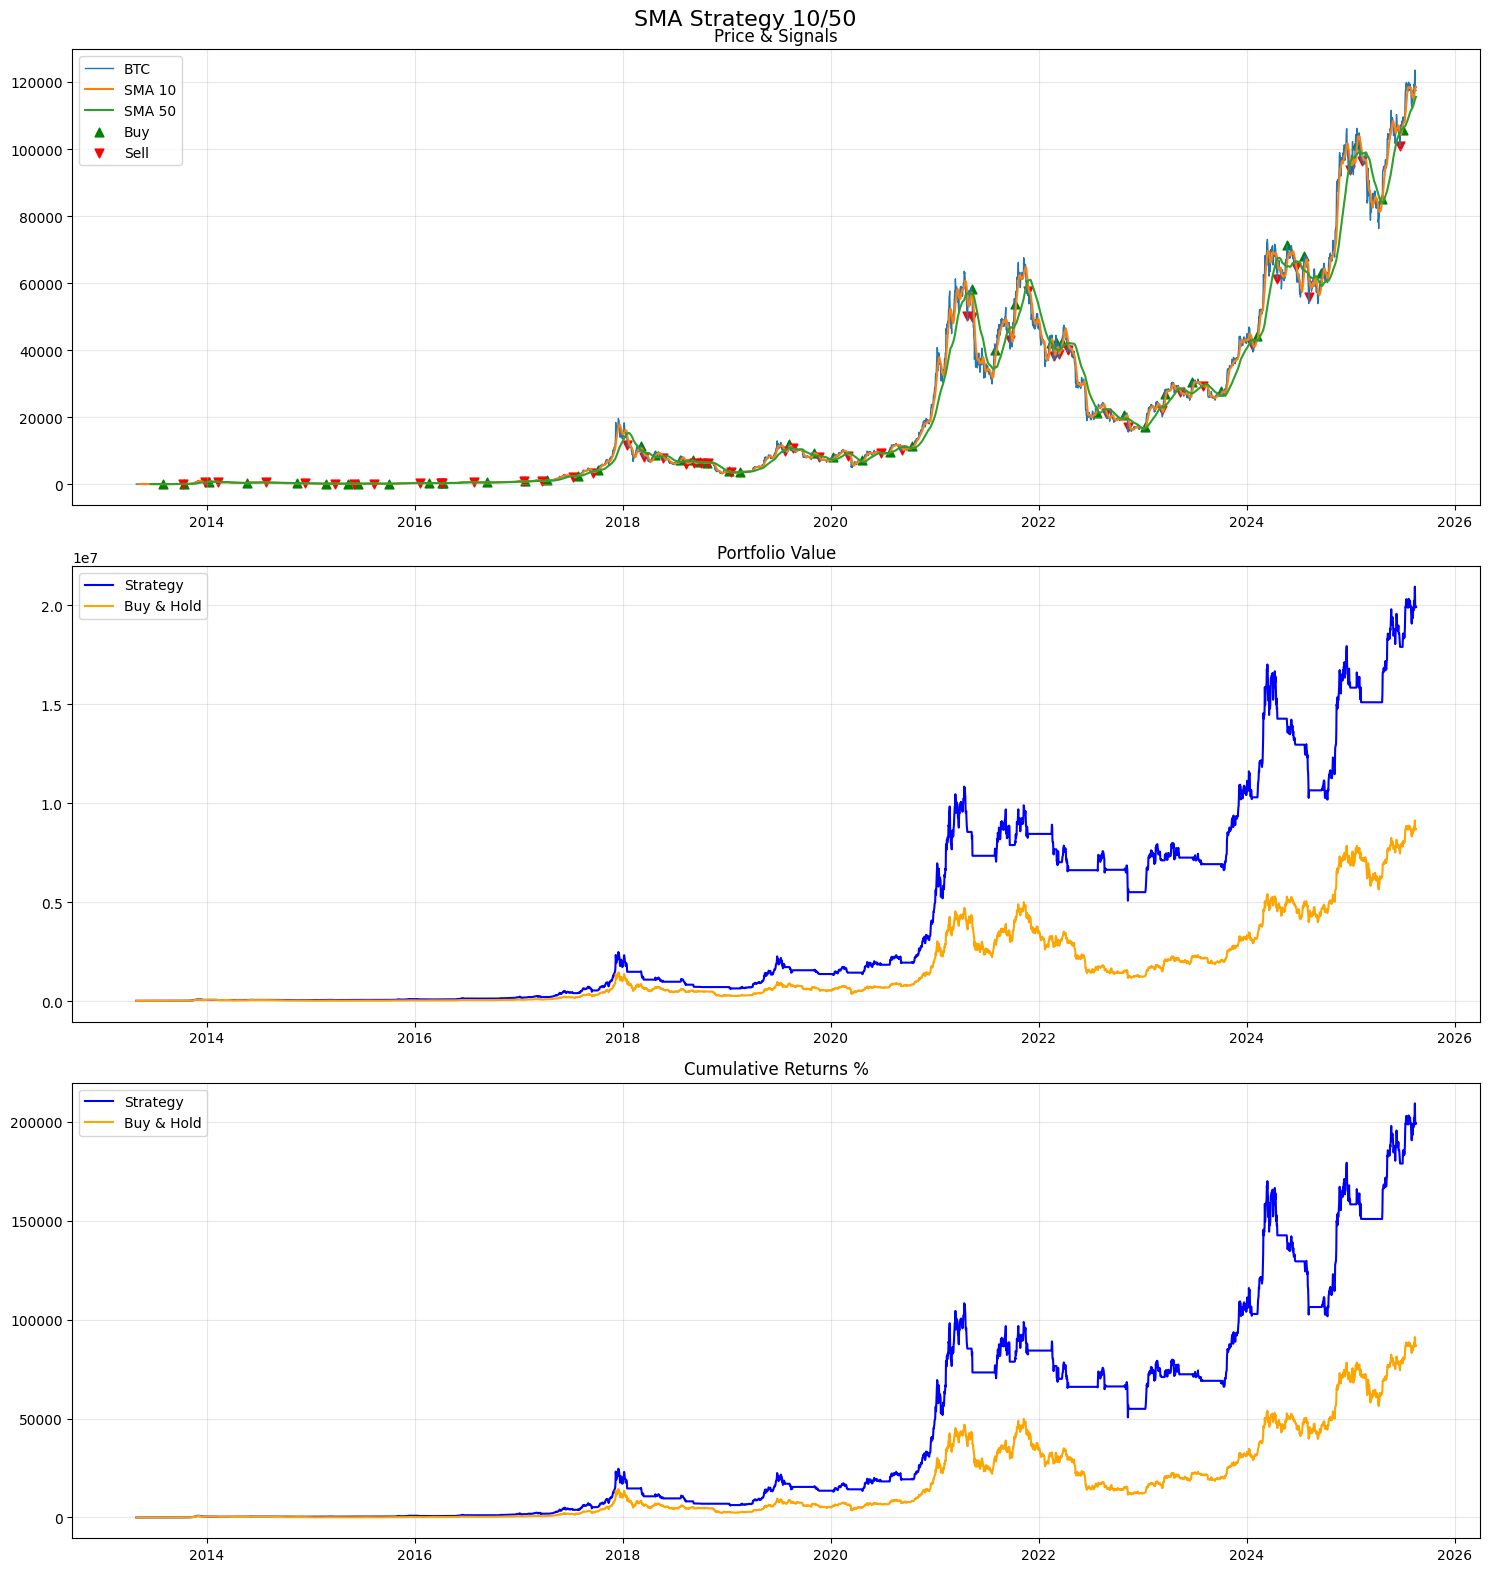

In [28]:
short = 10
long = 50
capital = 10000

print(f"\nrunning {short}/{long} crossover...")
results = sma_crossover_strategy(data, short, long, capital)

metrics = calc_metrics(results)

print("\nresults:")
print(f"{'metric':<30} {'strategy':<15} {'buy hold':<15}")
print("-" * 60)

for key, value in metrics.items():
    if 'Buy & Hold' in key:
        continue
    elif key.replace('(%)', '').strip() + ' Buy & Hold (%)' in metrics:
        bh_key = key.replace('(%)', '').strip() + ' Buy & Hold (%)'
        print(f"{key:<30} {value:<15} {metrics[bh_key]:<15}")
    elif 'Sharpe' in key and 'Buy & Hold' not in key:
        bh_key = 'Buy & Hold Sharpe'
        print(f"{key:<30} {value:<15} {metrics[bh_key]:<15}")
    elif key in ['Number of Trades', 'Win Rate (%)', 'Total Days']:
        print(f"{key:<30} {value}")

plot_results(results, short, long)

# walk forward
print("\nwalk forward test...")
wf_results = walk_forward_test(data, short, long, window_size=365, step_size=60)

if len(wf_results) > 0:
    print(f"tested {len(wf_results)} windows")
    print(f"avg return: {wf_results['Total Return (%)'].mean():.2f}%")
    print(f"std dev of total return: {wf_results['Total Return (%)'].std():.2f}%")
    print(f"positive windows: {(wf_results['Total Return (%)'] > 0).mean()*100:.1f}%")
    print(f"best: {wf_results['Total Return (%)'].max():.2f}%")
    print(f"worst: {wf_results['Total Return (%)'].min():.2f}%")

print("done")

plot_results(results, short, long)

<span style = "font-size : 30px">Results and Findings</span>

- The Strategy outperforms buy and hold by almost 100% in total returns, yielding double the returns when we use a typical SMA10 and SMA50.

- Maintains a sharpe ratio of 1.6 which is well above 1.0 which is the benchmark for a good portfolio. (for reference, S&P500 has a sharpe of roughly 0.7)

- The rolling walk forward test indicates that 63% of the windows yielded positive return which can be attributed to the bullish market of BTC

- Most likely only be extremely profitable in trending markets but can be optimized to work well in choppy markets by utilizing Exponential Moving Averages instead of SMA, in order to give greater weightage to recent prices.

